Sampling Extremal Points (n_steps=4)...
Tested 43 points.
Violations: 0
Max IC_red: 0.000000 (Capacity k: 0.000000)


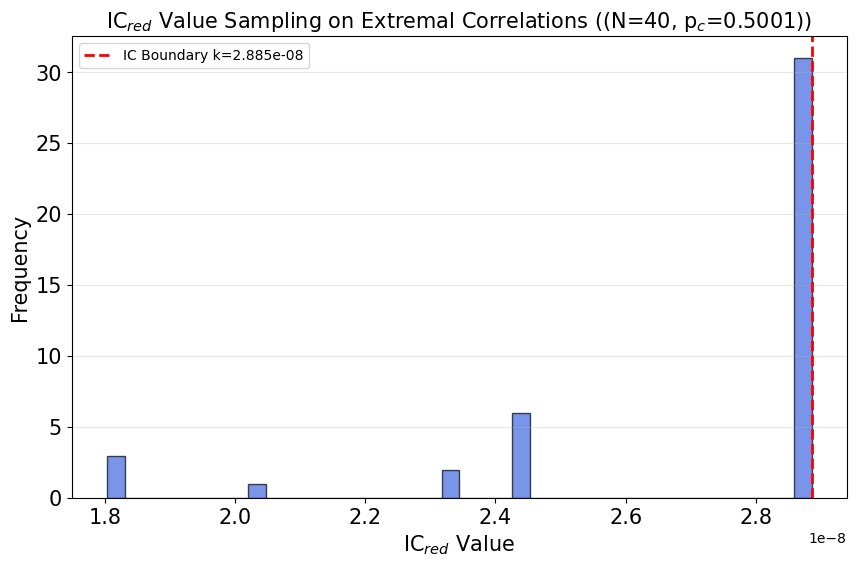

In [37]:
# This is the program which samples IC_{red} values over extremal 2-2-2 quantum correlations.
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# --- CORE MATH UTILITIES ---

def binary_entropy(p):
    if p <= 1e-12 or p >= 1 - 1e-12:
        return 0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def get_capacity(pc):
    """Calculates channel capacity k = 1 - h(pc)."""
    return 1 - binary_entropy(pc)

def kl_divergence(p, q, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(p * np.log2(p / q))

def get_projected_info(p_ab_target, p_ab_source):
    """Calculates redundant information via the convex hull of source distributions."""
    p_a = np.sum(p_ab_target, axis=1)
    p_b_source = np.sum(p_ab_source, axis=0)
    p_b_target = np.sum(p_ab_target, axis=0)
    p_a_given_b_src = p_ab_source / (p_b_source + 1e-15)
    p_a_given_b_tgt = p_ab_target / (p_b_target + 1e-15)
    
    projected_sum = 0
    for b_tgt in range(2):
        objective = lambda l: kl_divergence(
            p_a_given_b_tgt[:, b_tgt], 
            l * p_a_given_b_src[:, 0] + (1 - l) * p_a_given_b_src[:, 1]
        )
        # Yu & Scarani [18] suggest sampling or optimization for this step
        res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
        q_star = res.x * p_a_given_b_src[:, 0] + (1 - res.x) * p_a_given_b_src[:, 1]
        for a in range(4):
            if p_ab_target[a, b_tgt] > 1e-12:
                projected_sum += p_ab_target[a, b_tgt] * np.log2(q_star[a] / p_a[a])
    return projected_sum

# --- BARIZIEN & BANCAL EXTREMAL POINT GENERATION ---

def get_steered_angle(a_x, theta, s):
    """Equation (10) from the Nature Physics paper."""
    # tan^s(theta)
    multiplier = np.tan(theta) if s == 1 else (1.0 / np.tan(theta))
    # Handling arctan/tan carefully for full circle coverage
    return 2 * np.arctan(np.tan(a_x / 2.0) * multiplier)

def is_alternating(theta, a0, a1, b0, b1):
    """
    Theorem 1: Fully alternating condition. 
    Checks 0 <= [a_0^s] <= b0 <= [a_1^t] <= b1 < pi
    """
    # Map to [0, pi] as used in the paper's minimal scenario
    s_a0 = [get_steered_angle(a0, theta, s) % np.pi for s in [1, -1]]
    s_a1 = [get_steered_angle(a1, theta, s) % np.pi for s in [1, -1]]
    
    for a0_tilde in s_a0:
        for a1_tilde in s_a1:
            if not (0 <= a0_tilde <= b0 <= a1_tilde <= b1 < np.pi):
                return False
    return True

def get_extremal_correlation(theta, a0, a1, b0, b1):
    """Generates P(ab|xy) for the extremal point."""
    # |phi_theta> = cos(theta)|00> + sin(theta)|11>
    psi = np.array([np.cos(theta), 0, 0, np.sin(theta)])
    rho = np.outer(psi, psi)
    sz, sx = np.array([[1, 0], [0, -1]]), np.array([[0, 1], [1, 0]])
    
    def get_proj(angle):
        op = np.cos(angle) * sz + np.sin(angle) * sx
        return [0.5 * (np.eye(2) + op), 0.5 * (np.eye(2) - op)]

    alice_meas = [get_proj(a0), get_proj(a1)]
    bob_meas = [get_proj(b0), get_proj(b1)]
    
    p_ab_xy = np.zeros((2, 2, 2, 2))
    for x in range(2):
        for y in range(2):
            for a in range(2):
                for b in range(2):
                    p_ab_xy[a, b, x, y] = np.real(np.trace(rho @ np.kron(alice_meas[x][a], bob_meas[y][b])))
    return p_ab_xy

# --- INFORMATION CAUSALITY PROTOCOL ---

def check_ic_red_noisy(p_ab_xy, pc):
    """Calculates IC_red for a given quantum correlation."""
    p_a_bi = np.zeros((2, 4, 2)) 
    for a_idx in range(4):
        a1, a2 = (a_idx >> 1) & 1, a_idx & 1
        x = a1 ^ a2
        for i in range(2):
            y = i 
            for fract_a in range(2):
                for fract_b in range(2):
                    prob_box = 0.25 * p_ab_xy[fract_a, fract_b, x, y]
                    m = (fract_a ^ a1)
                    # Channel noise applied to Alice's message m
                    p_a_bi[i, a_idx, fract_b ^ m] += prob_box * pc
                    p_a_bi[i, a_idx, fract_b ^ (m ^ 1)] += prob_box * (1-pc)

    mis = []
    for i in range(2):
        p_joint = p_a_bi[i]
        p_a = np.sum(p_joint, axis=1)
        p_b = np.sum(p_joint, axis=0)
        mi = 0
        for a in range(4):
            for b in range(2):
                if p_joint[a, b] > 1e-12:
                    mi += p_joint[a, b] * np.log2(p_joint[a, b] / (p_a[a] * p_b[b]))
        mis.append(mi)
    
    ir = min(get_projected_info(p_a_bi[0], p_a_bi[1]), get_projected_info(p_a_bi[1], p_a_bi[0]))
    return mis[0] + mis[1] - ir


def check_ic_standard(p_ab_xy, pc):
    """
    Calculates the standard IC value: I(a_1 : B_1) + I(a_2 : B_2)
    following the 2-bit protocol.
    """
    # p_a_bi[i, a_idx, b_val]
    # i: Bob's bit choice (0 or 1)
    # a_idx: Alice's bit pair (00, 01, 10, 11)
    # b_val: Bob's guess for a_i
    p_a_bi = np.zeros((2, 4, 2)) 
    
    for a_idx in range(4):
        a1, a2 = (a_idx >> 1) & 1, a_idx & 1
        x = a1 ^ a2  # Alice's input strategy
        for i in range(2):
            y = i # Bob's input strategy to get a_i
            for fract_a in range(2):
                for fract_b in range(2):
                    prob_box = 0.25 * p_ab_xy[fract_a, fract_b, x, y]
                    m = (fract_a ^ a1) # Alice's message
                    # Apply noise to Alice's message bit
                    p_a_bi[i, a_idx, fract_b ^ m] += prob_box * pc
                    p_a_bi[i, a_idx, fract_b ^ (m ^ 1)] += prob_box * (1-pc)

    total_mi = 0
    for i in range(2):
        p_joint = p_a_bi[i]
        # We need I(a_i : B_i). a_idx represents (a1, a2). 
        # We marginalize to get the distribution of the specific bit a_i.
        p_bit_joint = np.zeros((2, 2)) # P(a_i, B_i)
        for a_idx in range(4):
            ai_val = (a_idx >> (1 - i)) & 1
            for b_val in range(2):
                p_bit_joint[ai_val, b_val] += p_joint[a_idx, b_val]
        
        # Calculate Mutual Information for bit i
        p_a = np.sum(p_bit_joint, axis=1)
        p_b = np.sum(p_bit_joint, axis=0)
        mi = 0
        for a in range(2):
            for b in range(2):
                if p_bit_joint[a, b] > 1e-12:
                    mi += p_bit_joint[a, b] * np.log2(p_bit_joint[a, b] / (p_a[a] * p_b[b]))
        total_mi += mi
        
    return total_mi

# --- MAIN EXECUTION ---

def run_simulation(n_steps, pc=0.4999):
    k = get_capacity(pc)
    ic_values = []
    violations = 0
    
    # Parametric sweep over the extremal manifold
    theta_range = np.linspace(0.1, np.pi/4, n_steps) # theta > 0 to avoid tan(theta) div
    angle_range = np.linspace(0, np.pi, n_steps)
    
    print(f"Sampling Extremal Points (n_steps={n_steps})...")
    
    for theta in theta_range:
        for a0 in angle_range:
            for b0 in angle_range:
                for a1 in angle_range:
                    for b1 in angle_range:
                        # APPLY THE NATURE PHYSICS CONDITION
                        if is_alternating(theta, a0, a1, b0, b1):
                            p_ab_xy = get_extremal_correlation(theta, a0, a1, b0, b1)
                            ic_val = check_ic_red_noisy(p_ab_xy, pc)
                            ic_values.append(ic_val)
                            if ic_val > k + 1e-8:
                                violations += 1

    print(f"Tested {len(ic_values)} points.")
    print(f"Violations: {violations}")
    if ic_values:
        print(f"Max IC_red: {max(ic_values):.6f} (Capacity k: {k:.6f})")

        # Visualization
        plt.figure(figsize=(10, 6))
        plt.hist(ic_values, bins=40, color='royalblue', edgecolor='black', alpha=0.7)
        plt.axvline(x=k, color='red', linestyle='--', linewidth=2, label=f'IC Boundary k={k:.3e}')
        plt.title(fr'IC$_{{red}}$ Value Sampling on Extremal Correlations ((N=40, p$_{{c}}$={pc}))',fontsize=15)
        plt.xlabel('IC$_{{red}}$ Value',fontsize=15)
        plt.ylabel('Frequency',fontsize=15)
        plt.xticks(fontsize=15)  # For x-axis numbers
        plt.yticks(fontsize=15)  # For y-axis numbers
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        # plt.savefig('ExtremalICRed.pdf')
        plt.show()
    else:
        print("No points met the alternating condition with current n_steps. Increase n_steps.")

if __name__ == "__main__":
    run_simulation(n_steps=4, pc=0.5001)

Sampling Extremal Points (n_steps=40)...
Tested 1114534 points.
Violations: 0
Max IC_red: 0.000000 (Capacity k: 2.885e-08)


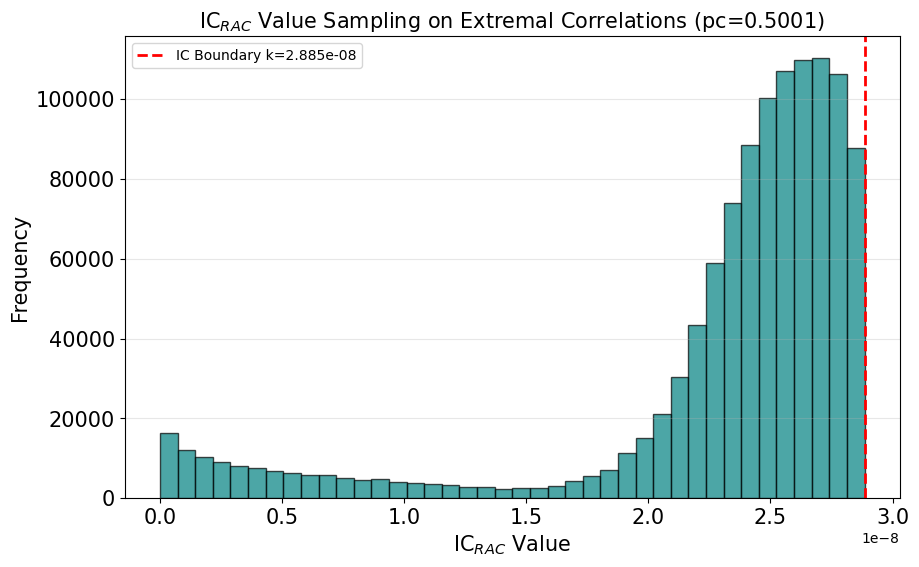

In [38]:
# This is the program which samples IC_{RAC} values over extremal 2-2-2 quantum correlations.
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# --- CORE MATH UTILITIES ---

def binary_entropy(p):
    if p <= 1e-12 or p >= 1 - 1e-12:
        return 0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def get_capacity(pc):
    """Calculates channel capacity k = 1 - h(pc)."""
    return 1 - binary_entropy(pc)

def kl_divergence(p, q, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(p * np.log2(p / q))

def get_projected_info(p_ab_target, p_ab_source):
    """Calculates redundant information via the convex hull of source distributions."""
    p_a = np.sum(p_ab_target, axis=1)
    p_b_source = np.sum(p_ab_source, axis=0)
    p_b_target = np.sum(p_ab_target, axis=0)
    p_a_given_b_src = p_ab_source / (p_b_source + 1e-15)
    p_a_given_b_tgt = p_ab_target / (p_b_target + 1e-15)
    
    projected_sum = 0
    for b_tgt in range(2):
        objective = lambda l: kl_divergence(
            p_a_given_b_tgt[:, b_tgt], 
            l * p_a_given_b_src[:, 0] + (1 - l) * p_a_given_b_src[:, 1]
        )
        # Yu & Scarani [18] suggest sampling or optimization for this step
        res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
        q_star = res.x * p_a_given_b_src[:, 0] + (1 - res.x) * p_a_given_b_src[:, 1]
        for a in range(4):
            if p_ab_target[a, b_tgt] > 1e-12:
                projected_sum += p_ab_target[a, b_tgt] * np.log2(q_star[a] / p_a[a])
    return projected_sum

# --- BARIZIEN & BANCAL EXTREMAL POINT GENERATION ---

def get_steered_angle(a_x, theta, s):
    """Equation (10) from the Nature Physics paper."""
    # tan^s(theta)
    multiplier = np.tan(theta) if s == 1 else (1.0 / np.tan(theta))
    # Handling arctan/tan carefully for full circle coverage
    return 2 * np.arctan(np.tan(a_x / 2.0) * multiplier)

def is_alternating(theta, a0, a1, b0, b1):
    """
    Theorem 1: Fully alternating condition. 
    Checks 0 <= [a_0^s] <= b0 <= [a_1^t] <= b1 < pi
    """
    # Map to [0, pi] as used in the paper's minimal scenario
    s_a0 = [get_steered_angle(a0, theta, s) % np.pi for s in [1, -1]]
    s_a1 = [get_steered_angle(a1, theta, s) % np.pi for s in [1, -1]]
    
    for a0_tilde in s_a0:
        for a1_tilde in s_a1:
            if not (0 <= a0_tilde <= b0 <= a1_tilde <= b1 < np.pi):
                return False
    return True

def get_extremal_correlation(theta, a0, a1, b0, b1):
    """Generates P(ab|xy) for the extremal point."""
    # |phi_theta> = cos(theta)|00> + sin(theta)|11>
    psi = np.array([np.cos(theta), 0, 0, np.sin(theta)])
    rho = np.outer(psi, psi)
    sz, sx = np.array([[1, 0], [0, -1]]), np.array([[0, 1], [1, 0]])
    
    def get_proj(angle):
        op = np.cos(angle) * sz + np.sin(angle) * sx
        return [0.5 * (np.eye(2) + op), 0.5 * (np.eye(2) - op)]

    alice_meas = [get_proj(a0), get_proj(a1)]
    bob_meas = [get_proj(b0), get_proj(b1)]
    
    p_ab_xy = np.zeros((2, 2, 2, 2))
    for x in range(2):
        for y in range(2):
            for a in range(2):
                for b in range(2):
                    p_ab_xy[a, b, x, y] = np.real(np.trace(rho @ np.kron(alice_meas[x][a], bob_meas[y][b])))
    return p_ab_xy

# --- INFORMATION CAUSALITY PROTOCOL ---


def check_ic_standard(p_ab_xy, pc):
    """
    Calculates the standard IC value: I(a_1 : B_1) + I(a_2 : B_2)
    following the 2-bit protocol.
    """
    # p_a_bi[i, a_idx, b_val]
    # i: Bob's bit choice (0 or 1)
    # a_idx: Alice's bit pair (00, 01, 10, 11)
    # b_val: Bob's guess for a_i
    p_a_bi = np.zeros((2, 4, 2)) 
    
    for a_idx in range(4):
        a1, a2 = (a_idx >> 1) & 1, a_idx & 1
        x = a1 ^ a2  # Alice's input strategy
        for i in range(2):
            y = i # Bob's input strategy to get a_i
            for fract_a in range(2):
                for fract_b in range(2):
                    prob_box = 0.25 * p_ab_xy[fract_a, fract_b, x, y]
                    m = (fract_a ^ a1) # Alice's message
                    # Apply noise to Alice's message bit
                    p_a_bi[i, a_idx, fract_b ^ m] += prob_box * pc
                    p_a_bi[i, a_idx, fract_b ^ (m ^ 1)] += prob_box * (1-pc)

    total_mi = 0
    for i in range(2):
        p_joint = p_a_bi[i]
        # We need I(a_i : B_i). a_idx represents (a1, a2). 
        # We marginalize to get the distribution of the specific bit a_i.
        p_bit_joint = np.zeros((2, 2)) # P(a_i, B_i)
        for a_idx in range(4):
            ai_val = (a_idx >> (1 - i)) & 1
            for b_val in range(2):
                p_bit_joint[ai_val, b_val] += p_joint[a_idx, b_val]
        
        # Calculate Mutual Information for bit i
        p_a = np.sum(p_bit_joint, axis=1)
        p_b = np.sum(p_bit_joint, axis=0)
        mi = 0
        for a in range(2):
            for b in range(2):
                if p_bit_joint[a, b] > 1e-12:
                    mi += p_bit_joint[a, b] * np.log2(p_bit_joint[a, b] / (p_a[a] * p_b[b]))
        total_mi += mi
        
    return total_mi

# --- MAIN EXECUTION ---

def run_simulation(n_steps, pc=0.4999):
    k = get_capacity(pc)
    ic_values = []
    violations = 0
    
    # Parametric sweep over the extremal manifold
    theta_range = np.linspace(0.1, np.pi/4, n_steps) # theta > 0 to avoid tan(theta) div
    angle_range = np.linspace(0, np.pi, n_steps)
    
    print(f"Sampling Extremal Points (n_steps={n_steps})...")
    
    for theta in theta_range:
        for a0 in angle_range:
            for b0 in angle_range:
                for a1 in angle_range:
                    for b1 in angle_range:
                        # APPLY THE NATURE PHYSICS CONDITION
                        if is_alternating(theta, a0, a1, b0, b1):
                            p_ab_xy = get_extremal_correlation(theta, a0, a1, b0, b1)
                            ic_val = check_ic_standard(p_ab_xy, pc)
                            ic_values.append(ic_val)
                            if ic_val > k + 1e-8:
                                violations += 1

    print(f"Tested {len(ic_values)} points.")
    print(f"Violations: {violations}")
    if ic_values:
        print(f"Max IC_red: {max(ic_values):.6f} (Capacity k: {k:.3e})")

        # Visualization
        plt.figure(figsize=(10, 6))
        plt.hist(ic_values, bins=40, color='teal', edgecolor='black', alpha=0.7)
        plt.axvline(x=k, color='red', linestyle='--', linewidth=2, label=f'IC Boundary k={k:.3e}')
        plt.title(fr'IC$_{{RAC}}$ Value Sampling on Extremal Correlations (N=40, p$_{{c}}$={pc})',fontsize=15)
        plt.xlabel('IC$_{{RAC}}$ Value',fontsize=15)
        plt.ylabel('Frequency',fontsize=15)
        plt.xticks(fontsize=15)  # For x-axis numbers
        plt.yticks(fontsize=15)  # For y-axis numbers
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.savefig('ExtremalRAC.pdf')
        plt.show()
    else:
        print("No points met the alternating condition with current n_steps. Increase n_steps.")

if __name__ == "__main__":
    run_simulation(n_steps=40, pc=0.5001)

<Figure size 640x480 with 0 Axes>